In [1]:
# First we import the module and start up the Matlab interpreter

import os
import numpy as np
from pace_neutrons import Matlab
m = Matlab()

swp = m.swpref()
swp.usemex = 1

Trying MATLAB version: 2022b (/mnt/ceph-training/course_materials/pace_env/lib/python3.11/site-packages/pace_neutrons/ctfs/pace_2022b.ctf))
Searching for Matlab 9.13 in /opt/matlab2021b
Searching for Matlab 9.13 in /opt
Trying MATLAB version: 2021b (/mnt/ceph-training/course_materials/pace_env/lib/python3.11/site-packages/pace_neutrons/ctfs/pace_2021b.ctf))
Searching for Matlab 9.11 in /opt/matlab2021b
Found Matlab 9.11 glnxa64 at /opt/matlab2021b
Interface opened
All features have moved to hor_config


!==================================================================!

!          ISIS utilities for visualization and analysis           !
!                   of neutron spectroscopy data                   !
!                          Herbert 4.0.0                           !
!------------------------------------------------------------------!


All features have moved to hor_config

!==================================================================!
!                           Horace 

### Fitting with Horace and SpinW

In this practical we will be doing a fit of the bcc-Iron dataset using both Horace and SpinW.

Start by looking back at the `day2_horace3_solution.ipynb` notebook where we did a fit of the iron dataset using an analytic Python function - copy the code to make a series of Q-cuts integrating in 20meV chunks between 80 and 160meV and then the code to fit this using an analytic function

*** Step 1 of 1; Read data for   200028 pixels -- processing data...
 ----->  retained     53790 pixels

*** Completed cat_pixels using 1 pages in 0.045788 sec.

*** Step 1 of 1; Read data for   284020 pixels -- processing data...
 ----->  retained     70892 pixels

*** Completed cat_pixels using 1 pages in 0.012511 sec.

*** Step 1 of 1; Read data for   458454 pixels -- processing data...
 ----->  retained     98358 pixels

*** Completed cat_pixels using 1 pages in 0.008156 sec.

*** Step 1 of 1; Read data for   508448 pixels -- processing data...
 ----->  retained    139698 pixels

*** Completed cat_pixels using 1 pages in 0.009552 sec.

*** Step 1 of 1; Read data for   467166 pixels -- processing data...
 ----->  retained    148412 pixels

*** Completed cat_pixels using 1 pages in 0.020617 sec.



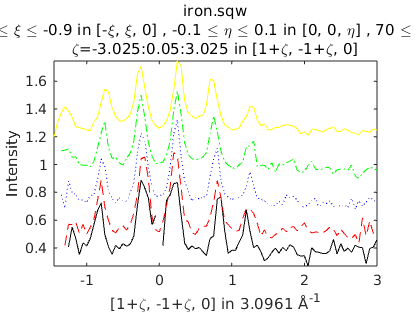

In [2]:
sqw_file = '/mnt/ceph-training/course_materials/sqw_files/iron.sqw'
proj = m.line_proj([1,1,0], [-1,1,0], 'type', 'rrr')

# Make an array of 1d cuts:
energy_range = range(80, 161, 20)
my_cuts = m.sqw.empty()
for i, en in enumerate(energy_range):
    my_cuts[i] = m.cut_sqw(sqw_file, proj, [-3,0.05,3], [-1.1,-0.9], [-0.1,0.1], [-10+en, 10+en])

# Plots the cuts using a vectorised operation, offsetting each cut by 0.3 units in y
m.acolor(['black', 'red', 'blue', 'green', 'yellow'])
m.amark(['+', 'o', '*', '.', 'x', 's'], 6)
my_cut_offset = my_cuts + np.arange(0, 1.3, 0.3)
m.dl(my_cut_offset)

In [3]:
# Parameters for the form factor of Fe2+
A=0.0706; a=35.008;  B=0.3589; b=15.358;  C=0.5819; c=5.561;  D=-0.0114

# Define the Python function
def fm_sqw(h, k, l, E, p):
    J = p[0]
    Gamma = p[1]
    Amp = p[2]
    E0 = 8*J * (1 - np.cos(np.pi * h) * np.cos(np.pi * k) * np.cos(np.pi * l))
    Biso = E / (1 - np.exp(-1.602 * E / 10))
    q2 = ((1/(2*2.87))**2) * (h**2 + k**2 + l**2)
    ff = A * np.exp(-a*q2) + B * np.exp(-b*q2) + C * np.exp(-c*q2) + D
    return (ff**2) * (Amp * Biso * 4 * Gamma * E0 / np.pi) / ((E**2 - E0**2)**2 + 4*(Gamma*E)**2)



 The configuration has been set to defaults. Type:
>>hpc_config
   to check if defaults are correct

Time to run fit with analytic Python function is [[8.569554]] s.


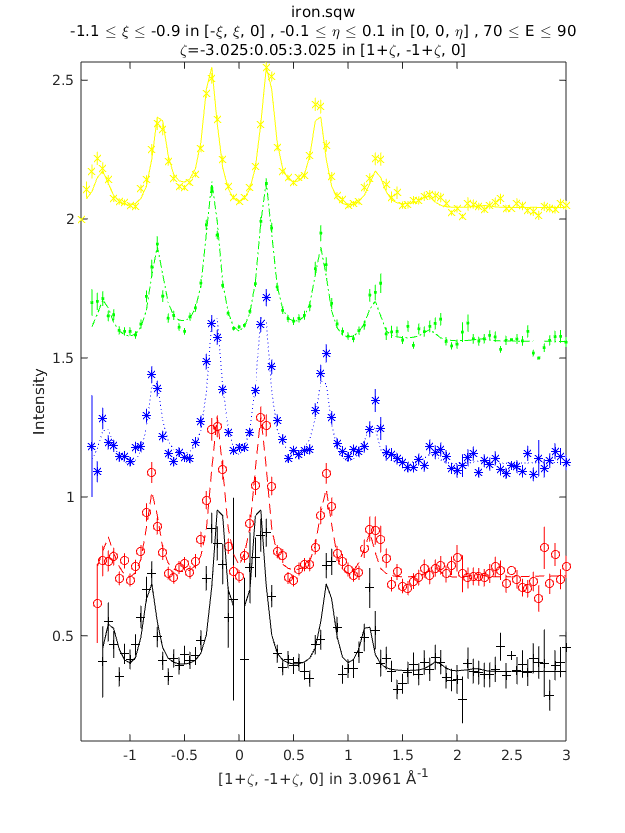

In [4]:
J = 35      # Exchange parameter in meV
Gamma = 30  # Intrinsic linewidth in meV (inversely proportional to excitation lifetime)
Amp = 300   # Magnitude of the intensity of the excitation (arbitrary units)

pars_in = [J, Gamma, Amp]

linear_bg = m.eval('@linear_bg')

mfobj = m.multifit_sqw(my_cuts)
mfobj = mfobj.set_fun(fm_sqw, pars_in)
mfobj = mfobj.set_bfun(linear_bg, [0.3, 0])
m.tic()
wfit, fitdata = mfobj.fit()
t0 = m.toc()

print(f'Time to run fit with analytic Python function is {t0} s.')

%matlab_fig -h 800 -w 600 -r 100

# Plots the cuts using a vectorised operation, offsetting each cut by 0.5 units in y
m.acolor(['black', 'red', 'blue', 'green', 'yellow'])
m.amark(['+', 'o', '*', '.', 'x', 's'], 6)
my_cut_offset = my_cuts + np.arange(0, 2.1, 0.5)
my_fit_offset = wfit + np.arange(0, 2.1, 0.5)
m.dp(my_cut_offset)
m.pl(my_fit_offset)

Now create a SpinW model of a body-centred cubic lattice (space group `I m -3 m` - you canuse the `'spgr', 'I m -3 m'` keyword in the `genlattice` method of SpinW) with an Fe$^{3+}$ (`'MFe3'`) ion at $(0,0,0)$.

Add one nearest neighbour exchange interaction labelled `'J1'` and set the magnetic structure as ferromagnetic with moments in the $c$ direction (note there are two Fe atoms in the unit cell).

In [5]:
spgr = 'I m -3 m'; a = 2.87;
fe = m.spinw();
fe.genlattice('lat_const', [a, a, a], 'angled', [90, 90, 90], 'spgr', spgr)
fe.addatom('r', [0, 0, 0], 'S', 2.5, 'label', 'MFe3')
fe.gencoupling();
fe.addmatrix('label', 'J1', 'value', -1);
fe.addcoupling('mat', 'J1', 'bond', 1);
fe.genmagstr('mode', 'direct', 'S', [[0, 0],
                                     [0, 0],
                                     [1, 1]])


Creating the bond list (maxDistance = 8 Å, nCell = 3x3x3)...

...168 bonds are retained out of 784 generated!



array([], shape=(0, 0), dtype=float64)

In [6]:
m.assignin('base', 'fe', fe)
spinw_sqw = m.evalin('base', "@fe.horace_sqw")

Temperature = 10   # Measurement done at 10K

pars_in_spinw = [J, Gamma, Temperature, Amp]

mfobj = m.multifit_sqw(my_cuts)
mfobj = mfobj.set_fun(spinw_sqw)
mfobj = mfobj.set_pin((pars_in_spinw, 'mat', ('J1',), 'resfun', 'sho', 'formfact', True, 'hermit', False))
mfobj = mfobj.set_free([1, 1, 0, 1])
mfobj = mfobj.set_bfun(linear_bg, [0.3, 0])

# Note that the form factor calculation is currently broken in Python - so the fit is not good.
# The time for an evaluation using SpinW is about 10x that of the analytic formula...

m.tic()
#wfit_spinw, fitdata_spinw = mfobj.fit()
wfit_spinw = mfobj.simulate()
t1 = m.toc()




Calculating COMMENSURATE spin wave spectra (nMagExt = 2, nHkl = 53790, nTwin = 1)...

The magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.

Calculation finished.

Calculating COMMENSURATE spin wave spectra (nMagExt = 2, nHkl = 70892, nTwin = 1)...

The magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.

Calculation finished.

Calculating COMMENSURATE spin wave spectra (nMagExt = 2, nHkl = 98358, nTwin = 1)...

The magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.

Calculation finished.

Calculating COMMENSURATE spin wave spectra (nMagExt = 2, nHkl = 139628, nTwin = 1)...

The magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.

Calculation finished.

Calculating COMMENSURATE 

Time to run fit with SpinW function is [[5.937798]] s.


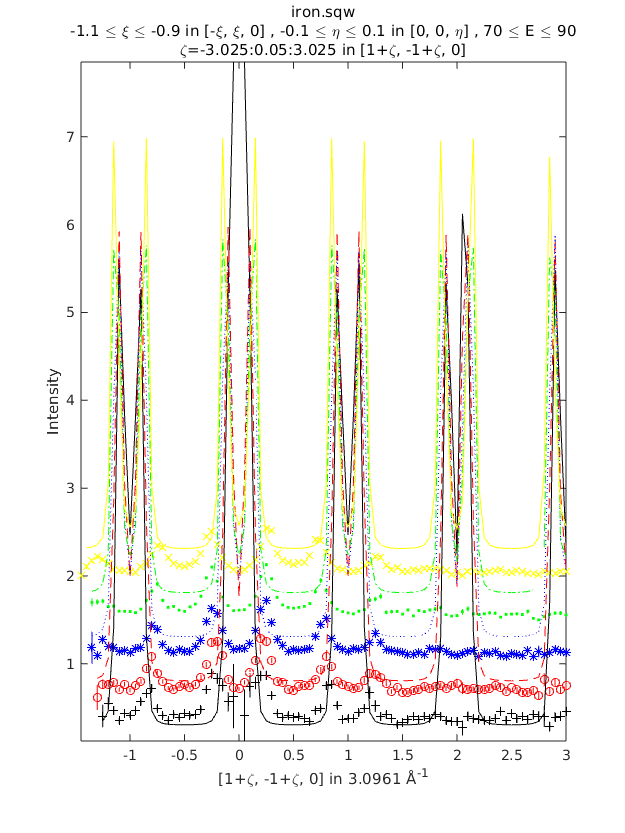

In [7]:
print(f'Time to run fit with SpinW function is {t1} s.')

%matlab_fig -h 800 -w 600 -r 100

# Plots the cuts using a vectorised operation, offsetting each cut by 0.5 units in y
m.acolor(['black', 'red', 'blue', 'green', 'yellow'])
m.amark(['+', 'o', '*', '.', 'x', 's'], 6)
my_cut_offset = my_cuts + np.arange(0, 2.1, 0.5)
my_fit_offset = wfit_spinw + np.arange(0, 2.1, 0.5)
m.dp(my_cut_offset)
m.pl(my_fit_offset)